$\newcommand{mb}[1]{\mathbf{#1}}$

<!-- dom:TITLE: Partial differential equations and finite difference methods. -->
#  Finite difference methods for two-point value problems
<!-- dom:AUTHOR: Anne Kværnø -->
<!-- Author: -->  
**Anne Kværnø, André Massing**

Date: **April 19, 2021**

In [2]:
from IPython.core.display import HTML
def css_styling():
    try:
        with open("tma4125.css", "r") as f:
            styles = f.read()
            return HTML(styles)
    except FileNotFoundError:
        pass #Do nothing

# Comment out next line and execute this cell to restore the default notebook style 
css_styling()

## Introduction
In this note the finite difference method for solving partial differential equations
(PDEs) will be presented. 

Roughly speaking, a finite difference method consists of the following steps: 
1. Discretize the domain on which the equation is defined.  

2. On each grid point, replace the derivatives with an approximation, using the values in neighbouring grid points. 

3. Replace the exact solutions by their approximations.

4. Solve the resulting system of equations. 

We will first see how to find approximations to the
derivative of a function, and then how these can be used to solve boundary value
problems like

$$
u'' + p(x) u' + q(x) u = r(x), \qquad a \leq x \leq b, \qquad u(a)=u_a, \quad
u(b)=u_b,
$$

and time dependent partial differential equations like the heat equation

$$
u_t = u_{xx}.
$$

The technique described here is, however, applicable to several other PDEs,
and it is therefore important to try to understand the underlying idea.

## Numerical differentiation

This is the main tool for finite difference methods.

Given a sufficiently smooth function $u$. How can we find an approximation to
$u'(x)$ or $u''(x)$ in some given point $x$, just by using evaluation of the
function itself?

[The derivative of
$u$](https://wiki.math.ntnu.no/tma4100/tema/differentiation?&#definisjonen_av_den_deriverte_gitt_som_en_grenseverd)
is defined as

$$
u'(x) = \lim_{h\rightarrow 0} \frac{u(x+h)-u(x)}{h}.
$$

Given a sufficiently small value of $h$, the right hand side can be used an
approximation to the *first derivative* $u'(x)$. A small collection of the most used approximations to the first order derivative
$u'(x)$ is:

$$
u'(x) \approx \left\{
   \begin{array}{ll}
     \displaystyle \frac{u(x+h)-u(x)}{h} =: \partial^+ u(x), \qquad & \text{Forward difference,} \\ 
     \displaystyle \frac{u(x)-u(x-h)}{h} =: \partial^- u(x), & \text{Backward difference,} \\ 
     \displaystyle \frac{u(x+h)-u(x-h)}{2h} =: \partial^{\circ} u(x), & \text{Central difference.}
   \end{array} \right.
$$

The first one is taken directly from the definition, and so is the second, and the
third is just the mean of the first two.

A common approximation to the *second
derivative* is

$$
u''(x) \approx \partial^+ \partial^- u(x) =  \frac{u(x+h)-2u(x)+u(x-h)}{h^2}.
$$

**Numerical example 1:**
Test the method on the function $u(x)=\sin(x)$ at the point $x=\frac{\pi}{4}$.
Compare with the exact derivative. Try different step sizes, e.g.  $h=0.1, h=0.01, h=0.001$.
Notice how the error in each case changes with $h$.

In [3]:
%matplotlib inline

from numpy import *               
from scipy.sparse import diags	        # Greate diagonal matrices
from scipy.linalg import solve	        # Solve linear systems
from matplotlib.pyplot import *     	
from mpl_toolkits.mplot3d import Axes3D  # For 3-d plot
from matplotlib import cm 
newparams = {'figure.figsize': (8.0, 4.0), 'axes.grid': True,
             'lines.markersize': 8, 'lines.linewidth': 2,
             'font.size': 14}
rcParams.update(newparams)
from numpy import *

In [4]:
# Numerical differentiation

# Forward difference
def diff_forward(u, x, h=0.1):
    return (u(x+h)-u(x))/h

# Backward difference
def diff_backward(u, x, h=0.1):
    return (u(x)-u(x-h))/h
 
# Central difference for f'(x):
def diff_central(u, x, h=0.1):
    return (u(x+h)-u(x-h))/(2*h)
# end of diff_central

# Central difference for f''(x):
def diff2_central(u, x, h=0.1):
    return (u(x+h)-2*u(x)+u(x-h))/h**2
# end of diff2_central

In [6]:
# Numerical example 1
x = pi/4
du_exact = cos(x)
ddu_exact = -sin(x)
for h in [0.1, 0.01, 0.001]:
    u = sin
    du = diff_forward(u, x, h)
    print(f'Approximations to the first derivative for h = {h}')
    print(f'Forward difference:  du  = {du:12.8f},  Error = {du_exact-du:10.3e}')
    du = diff_backward(u, x, h)
    print(f'Backward difference: du  = {du:12.8f},  Error = {du_exact-du:10.3e}')
    du = diff_central(u, x, h)
    print(f'Central difference:  du  = {du:12.8f},  Error = {du_exact-du:10.3e}')
    print('Approximation to the second derivative') 
    ddu = diff2_central(u, x, h)
    print(f'Central difference:  ddu = {ddu:12.8f}, Error = {ddu_exact-ddu:10.3e}')

Approximations to the first derivative for h = 0.1
Forward difference:  du  =   0.67060297,  Error =  3.650e-02
Backward difference: du  =   0.74125475,  Error = -3.415e-02
Central difference:  du  =   0.70592886,  Error =  1.178e-03
Approximation to the second derivative
Central difference:  ddu =  -0.70651772, Error = -5.891e-04
Approximations to the first derivative for h = 0.01
Forward difference:  du  =   0.70355949,  Error =  3.547e-03
Backward difference: du  =   0.71063050,  Error = -3.524e-03
Central difference:  du  =   0.70709500,  Error =  1.179e-05
Approximation to the second derivative
Central difference:  ddu =  -0.70710089, Error = -5.893e-06
Approximations to the first derivative for h = 0.001
Forward difference:  du  =   0.70675311,  Error =  3.537e-04
Backward difference: du  =   0.70746022,  Error = -3.534e-04
Central difference:  du  =   0.70710666,  Error =  1.179e-07
Approximation to the second derivative
Central difference:  ddu =  -0.70710672, Error = -5.890e-0

## Error analysis
In this case the error analysis is quite simple: Perform a Taylor expansion of the
error around $x$. The Taylor expansion becomes a power series in $h$.

The expansion for the error of the forward difference is:

\begin{align*}
e(x;h) &= u'(x) - \frac{u(x+h)-u(x)}{h} 
\\
       &= u'(x) - \frac{(u(x)+u'(x)h + \frac{1}{2}u''(\xi)h^2) - u(x)}{h}
       \\
       &= -\frac{1}{2}u''(\xi)h
\end{align*}

for some $\xi\in (x,x+h)$.  

The expansion for the error of the central difference is slightly more complicated:

\begin{align*}
e(x; h) &= u'(x) - \frac{u(x+h)-u(x-h)}{2h} \\ 
        &= u'(x) \\ &- \frac{\big(u(x)+u'(x)h + \frac{1}{2} u''(x)h^2 + \frac{1}{6} u'''(\xi_1)h^3 \big) - \big(u(x)-u'(x)h + \frac{1}{2} u''(x)h^2 - \frac{1}{6} u'''(\xi_2)h^3\big)}{2h} \\ 
        &= -\frac{1}{12}\big(u'''(\xi_1) + u'''(\xi_2)\big)h^2  \\ 
        &= -\frac{1}{6}u'''(\eta)h^2, \qquad \qquad \text{ for some } \eta \in (x-h, x+h).
\end{align*}

In the last step, the two remainder terms have been combined by the intermediate value theorem. The error for the approximation of the
second order derivative can be found in a similar manner.

**Problem 1**: Use Taylor expansion to show that
for 
$u \in C^4([a,b])$

$$
 | \partial^+ \partial^-u(x) - u''(x) |
=
\mathcal{O}(h^2).
$$

**Reminder.** The order of an approximation is $p$ if there exist a constant $C$ independent on $h$ such that

$$
\lvert e(h;x)\rvert \leq C h^p
$$

for all sufficiently small $h > 0$. 

In practice, it is sufficient to show that the power expansion of the error satisfies

$$
e(x,h)=C_ph^{p}+ C_{p+1}h^{p+1} + \dotsm, \qquad \text{ with } C_p \not=0
$$

The forward and backward approximations
are of order 1, the central differences of order 2. 

We are going to use these formulas a lot in the sequel, so let us just summarize
the results, including the error terms: 

**Difference formulas for derivatives:**

\begin{align*}
   u'(x) &= \left\{
   \begin{array}{ll} \displaystyle
     \underbrace{\frac{u(x+h)-u(x)}{h}}_{\partial^+u(x)} - \frac{h}{2}u''(\xi), \ & \text{Forward difference} \\ \mbox{} \\ 
      \displaystyle 
     \underbrace{\frac{u(x)-u(x-h)}{h}}_{\partial^-u(x)} + \frac{h}{2}u''(\xi), & \text{Backward difference} \\ \mbox{} \\ 
     \displaystyle
     \underbrace{\frac{u(x+h)-u(x-h)}{2h}}_{\partial^{\circ}u(x)} - \frac{h^2}{6}u'''(\xi).\qquad  & \text{Central difference} 
   \end{array}  \right. \\ \mbox{} \\ 
   u''(x) & = 
  \underbrace{\frac{u(x+h)-2u(x)+u(x-h)}{h^2}}_{\partial^+\partial^-u(x)} - \frac{h^2}{12}u^{(4)}(\xi), \qquad  
\text{Central difference}
\end{align*}

## Finite difference method for the 1d Poisson problem

We start our journey with the the following problem.
Let $[a,b] \subset \mathbb{R}$ be a finite interval, together
with a function $f: [a, b] \to \mathbb{R}$. Then the _two-point
boundary value problem_ is to find a $u: [a, b] \to \mathbb{R}$
such that

\begin{gather}
- u''(x) = f(x) \quad \forall x \in (a,b),
\tag{1a}
\\
u(a) = u_a, \quad  u(b) = u_b
\tag{1b}
\end{gather}
where $u_a$ and $u_b$ are given values.

__For the rest of the this section we will 
assume that $a = 0, b = 1$__

Note that so this is __second order__ ordinary differential equations and thus requires two addition values to determine a solution completely, one on each boundary point.

This is contrast of the second order initial value problem
\begin{align*}
u'' &= f(t,u(t), u'(t)) \quad \forall\; t \in (0,1)
\\
u(0) &= u_0,
\\
u'(0) &= u_1
\end{align*}
where we have two conditions on the left end point.
The main reason is that in the former case, $x$ is a space variable,
while in the latter case, $t$ is a time variable.

Instead of trying to compute $u(x)$ exactly,
we will now try to compute a numerical approximation
$u_{\Delta}$ of $u(x)$. As many times before we start by 
defininig $n+1$ equally spaced points $\{x_i\}_{i=0}^n$ 
with a grid size $h = \tfrac{b-a}{n}$ so that
$$
x_i := a + i h \quad
\text{for } i = 0, 1, \ldots, n.
$$

Then the second order derivative $u''$ can be approximated by the
__central difference operator__ defined by

\begin{align}
\partial^+ \partial^- u(x_i)
:=  \dfrac{u(x_i+h) - 2 u(x_i) + u(x_i-h)}
{h^2}
\approx u''(x_i) = -f(x_i)
\end{align}

Now the idea is to numerically solve for the two-point boundary 
value problem by associating an unknown variable $U_i := u_{\Delta}(x_i)$ to every 
grid point $x_i$ for $i=0,\ldots N$. Of course, the goal
is to find an $U_i \approx u(x_i)$. Keeping in mind that $-u'' = f$,
we demand that at the __internal__ grid points $\{x_i\}_{i=1}^{N}$
the unknows satisfy

\begin{align}
-\partial^+\partial^- U_i
=
- \dfrac{U_{i+1} - 2 U_i + U_{i-1}}
{h^2}
= f(x_i) \quad \text{for } i = 1,\ldots N-1.
\end{align}

Note that at $x_0$ and $x_N$, $\partial^+\partial^- U_i$ is not well-defined
since we don't have a point left (respective right) of $x_0$ (respective $x_N$). This leads to the *non-quadratic* $N-1 \times N+1$ linear system of the form

\begin{align}
\dfrac{1}{h^2}
\underbrace{
\begin{bmatrix}
-1 & 2  & -1 & & &
\\
  & -1 & 2  & -1 & & 
\\
  &    & -1 & 2 & -1 & & 
\\
 &     &    & \ddots &\ddots & \ddots &
\\
&      &    &        &  -1 & 2 & -1
\end{bmatrix}
}_{\widetilde{A}}
\underbrace{
\begin{bmatrix}
U_0
\\
U_1
\\
U_2
\\
U_3
\\
\vdots
\\
U_{N}
\end{bmatrix}
}_{\widetilde{U}}
=
\underbrace{
\begin{bmatrix}
f(x_1)
\\
f(x_2)
\\
f(x_3)
\\
\vdots
\\
f(x_{N-1})
\end{bmatrix}
}_{\widetilde{F}}
\end{align}

Out of reflex we immediately ask whether this system
is _always solvable_ and has a _unique solution_.
Unfortunately the matrix $\widetilde{A}$ above is non-quadratic with more columns than rows and thus has a nontrivial kernel.
An example is $U_0 = U_1 = U_2 = \ldots U_{N-1} = U_N = c$ for any constant $c$. That's where the boundary conditions come into play!!

So to close the system, let's incorporate the boundary condition by setting
$$
U_0 = u_a, \quad U_{N} = u_b.
$$
These trivial equations can be added to the system above,
leading to final problem:

Find $U = [U_0, \ldots, U_N] \in \mathbb{R}^{N+1}$ such that

\begin{align}
\dfrac{1}{h^2}
\underbrace{
\begin{bmatrix}
h^2
\\
-1 & 2  & -1 & & &
\\
  & -1 & 2  & -1 & & 
\\
  &    & -1 & 2 & -1 & & 
\\
 &     &    & \ddots &\ddots & \ddots &
\\
&      &    &        &  -1 & 2 & -1
\\
&      &    &        &  &  & h^2
\end{bmatrix}
}_{{A}}
\underbrace{
\begin{bmatrix}
U_0
\\
U_1
\\
U_2
\\
U_3
\\
\vdots
\\
U_{N-1}
\\
U_{N}
\end{bmatrix}
}_{{U}}
=
\underbrace{
\begin{bmatrix}
u_0
\\
f(x_1)
\\
f(x_2)
\\
f(x_3)
\\
\vdots
\\
f(x_{N-1})
\\
u_b
\end{bmatrix}
}_{{F}}
\end{align}

## Implementation

In [8]:
import numpy as np
import matplotlib.pyplot as plt

def fdm_poisson1d_matrix(N):
    
    """Computes the finite difference matrix for the Poisson problem in 1D

    Parameters:
    N (int): Number of grid points :math:`\{x_i}_{i=0}^N` counting from 0.

    Returns:
    A (ndarray): Finite difference matrix 

    """
    # Gridsize
    h = 1.0/N

    # Define zero matrix A of right size and insert
    A = np.zeros((N+1, N+1))
    
    # Define tridiagonal part of A
    hh = h*h
    for i in range(1, N):
        A[i, i-1] =  -1/hh
        A[i, i] = 2/hh
        A[i, i+1] = -1/hh
    
    # Set a_00 = a_NN to 1 to incorporate boundary condition
    A[0,0] = 1
    A[N,N] = 1
    
    return A

def apply_bcs(F, bcs):
    "Incorporate boundary condition into rhs vector"
    F[0], F[-1] = bcs[0], bcs[1] 

In [25]:
# Import linear algebra module
import scipy.linalg as la

# Analytical reference solution
u = lambda x: np.sin(2*np.pi*x) 
f = lambda x: (2*np.pi)**2*np.sin(2*np.pi*x) 

N = 10

# Define grid points
x = np.linspace(0, 1, N+1)
xfine = np.linspace(0, 1, 10*N)

# Compute A and F
A = fdm_poisson1d_matrix(N)
F = f(x)
#print(A)
#print(F)

In [26]:
# Incorporate bcs 
bcs = [u(0), u(1)]
apply_bcs(F, bcs)

# Solve AU = F
# (We will introduce a sparse solver when we look at 2D problems)
U = la.solve(A, F)

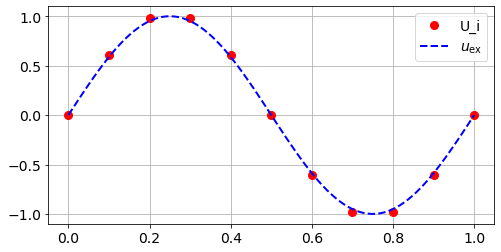

In [27]:
# Plot discrete solution on chosen discretization grid
plt.plot(x, U, "or", label="U_i")
plt.plot(xfine, u(xfine), "--b", label="$u_{\mathrm{ex}}$")
plt.legend()
# Show figure (for non inline plotting)
plt.show()

**Problem 2** 

Apply the method of __manufactured solutions__: Take a known function $u(x)$ and 
compute corresponding data $f$ and $u_a$, $u_b$ such that $u$ is the solution to 
the two-point two-point boundary problem (1a)--(1b).

For example you can pick $u(x) = \cos(2\pi x)$. What is then $f = - u''$,
$u_a = u(0)$, $u_b = u(1)$?

After having picked your favorite (smooth) manufactured solution,
you can compute the error 
$$
\mathrm{err(h)} = \mathrm{err(N)} = \max_{i \in \{0,\ldots N\}}|U_i - u(x_i)|
$$
as a function of $h = 1/N$.

For $N_1 = 5, N_2= 10, N_3 = 20, N_4 = 40, N_5 =80$
* compute and plot the numerical solution and the analytical solution
* record the resulting $\mathrm{err(N)}$

At the end of your experiment, compute the __experimental order of convergence__ 
for each refinement level $N_2, \ldots, N_5$ defined
$$
EOC(N_i) = \dfrac{\log(\mathrm{err}(N_i)) - \log(\mathrm{err}(N_{i-1}))}
{\log(N_{i-1}) - \log(N_i)}
$$

What order of convergence do you expect and what do you get?

## General two point boundary problems (BVP)

In the following, we will discuss the numerical solution
of a two-point boundary value problem of the form

$$
u'' + p(x) u' + q(x) u = r(x), \qquad a \leq x \leq b, \qquad u(a)=u_a, \quad u(b)=u_b,
$$

where $p$, $q$ are given functions of $x$ and the boundary values $u_a$ and $u_a$ are given constants.

As before, a finite difference method for this problem is constructed with the following steps:  

**Step 1:**
Given the interval $[a,b]$. Choose some $N \in \mathbb{N}$, define the step size $h=(b-a)/N$, and
the grid points $x_i=a+ih$, $i=0,1,\dotsc,N$. 

**Step 2:**
For each interior grid point $x_i$, $i=1,\dotsc,N-1$, replace the derivatives by their approximations in the BVP. The result is:

$$
\frac{u(x_i+h)-2u(x_i)+u(x_i-h)}{h^2} + p(x_i) \frac{u(x_i+h)-u(x_i-h)}{2h} + q(x_i) u(x_i) + \mathcal{O}(h^2) = r(x_i)
$$

for each $i=1,2\dotsc,N-1$, and the term $\mathcal{O}(h^2)$ represents the errors in the difference formulas. 

**Step 3:** Ignore the error term, and replace the exact solution $u(x_i)$ by its numerical (and still unknown) approximation $U_i$:

$$
\frac{U_{i+1}-2U_i+U_{i-1}}{h^2} + p(x_i)\frac{U_{i+1}-U_{i-1}}{2h} + q(x_i) U_i =  r(x_i), \qquad i=1,\dotsc,N-1.
$$

This is the *discretization* of the BVP. 

If we now include the two boundary values as equations

$$
U_0 = u_a
\qquad\text{ and }\qquad
U_N = u_b,
$$

the discretization is a linear system of equations

$$
A \mb{U} = \mb{b},
$$

where $A$ is an $(N+1)\times (N+1)$ matrix and  $\mb{U} = [U_0,\dotsc,U_{N}]^T$. Or more specific, by multiplying the equations by $h^2$ we end up with:

$$
A =  \left[ \begin{array}{ccccccc}
      1 & 0 & &  \\ 
      v_1 & d_1 & w_1 & & &  \\ 
        & v_2 & d_2 & w_2 &  \\ 
        & & v_3 & \ddots & \ddots & \\ 
        & & & \ddots & \ddots & w_{N-2} \\ 
        & & & & v_{N-1} & d_{N-1} & w_{N-1}  \\ 
        & & & & &  0 & 1
    \end{array} \right]
    \qquad \text{with} \qquad
    \begin{array}{l}
    \displaystyle v_i =1-\frac{h}{2}p(x_i) \\ 
    \displaystyle d_i = -2 + h^2q(x_i) \\ 
    \displaystyle w_i = 1+\frac{h}{2}p(x_i)
    \end{array}.
$$

The right hand side $\mb{b}$ is given by

$$
\mb{b} = [u_a, h^2r(x_1), \dotsc, h^2r(x_{N-1}), u_b]^T.
$$

Obviously, the first and last equations are trivial to solve, and are therefore often included in the right hand side.

**Step 4:** Solve  $A \mb{U} = \mb{b}$ with respect to $\mb{U}$.

**Example 1:**
We consider the equation

$$
u'' + 2u' - 3u = 9x, \qquad u(0)=u_a = 1, \quad u(1)=u_b = e^{-3}+2e-5\approx 0.486351,
$$

with exact solution $u(x)= e^{-3x}+2e^{x}-3x-2$.

Choose $N$, let $h=1/N$. Use the central differences for $u'$ and $u''$, such that

$$
\frac{u(x_i+h)-2u(x_i)+u(x_i-h)}{h^2} + 2 \frac{u(x_i+h)-u(x_i-h)}{2h} -3
u(x_i) + \mathcal{O}(h^2) =  9 x_i, \qquad i=1,\dotsc, N.
$$

Let $U_i \approx u(x_i)$. Multiply by $h^2$ on both sides, include $U_0=u_a$ og $U_N=u_b$ and clean the mess:

\begin{align*}
 U_0 &= 1, \\ 
 (1-h)U_{i-1} + (-2-3h^2)U_i + (1+h)U_{i+1} &= 9x_ih^2, && i=1, \ldots, N-1, \\ 
 U_N &= 0.486351.
\end{align*}

To be even more concrete, for $N=4$, we get $h=0.25$. The linear system of equations becomes

$$
\left( \begin{array}{ccccc}
  1 & 0 & 0 & 0 & 0\\ 
  0.75 & -2.1875 & 1.25 & 0 & 0\\ 
  0 & 0.75 & -2.1875 & 1.25 & 0\\ 
  0 & 0 & 0.75 & -2.1875 & 1.25 \\ 
  0 & 0 & 0 & 0 & 1
\end{array} \right) 
\left(\begin{array}{c} U_0 \\ U_1 \\ U_2 \\ U_3 \\ U_4
\end{array} \right)
=
\left( \begin{array}{c} 1. \\ 0.140625 \\ 0.28125  \\  0.421875 \\  0.48635073
\end{array} \right).
$$

The first and the last equation is trivial to solve, so in practice you have a system of 3 equations in 3 unknowns,

$$
\left(\begin{array}{ccc}
   -2.1875 & 1.25 & 0 \\ 
  0.75 & -2.1875 & 1.25 \\ 
   0 & 0.75 & -2.1875
\end{array} \right)
\left( \begin{array}{c} U_1 \\ U_2 \\ U_3  \end{array} \right) =
\left( \begin{array}{c} 0.140625-0.75\cdot 1 \\ 0.28125  \\  0.421875-1.25 \cdot
0.48635073  \end{array} \right),
$$

with the solution

$$
U_1 \approx 0.293176, \qquad U_2 \approx 0.025557, \qquad  U_3 \approx 0.093820.
$$

For comparison, the analytic solution in these points is

$$
u(0.25) \approx 0.290417, \qquad u(0.5) \approx 0.020573, \qquad u(0.75) \approx
0.089400.
$$

## Implementation
For simplicity, the implementation below is only done for BVPs with constant
coefficients, that is $p(x)=p$ and $q(x)=q$. This makes the diagonal, sub- and
super-diagonals constant, except at the first and the last row.  
An extra function is included to construct *tridiagonal* matrices,
that is, matrices where all entries outside the diagonal, sub-diagonal,
and super-diagonal are equal to zero.

The implementation consist of:
1. Choose $N$, let $h=(b-a)/N$ and $x_i=a+ih$, $i=0,\dotsc,N$.

2. Construct the matrix $A\in \mathbb{R}^{(N+1)\times (N+1)}$ and the vector $b\in\mathbb{R}^{N+1}$. The matrix $A$ is tridiagonal, and except from the first and last row, has the elements  $v=1-\frac{h}{2}p$ below the diagonal, $d = -2 + h^2 q$ as diagonal elements and  $w = 1+\frac{h}{2}p$ above the diagonal. 

3. Construct the vector $\mb{b} = [b_0,\dotsc,b_N]^T$ with elements $b_i=h^2r(x_i)$ for $i=1,\dotsc,N-1$.

4. Modify the first and the last row of the matrix $A$ and the first and last element of the vector $\mb{b}$, depending on the boundary conditions. 

5. Solve the system $A\mb{U} = \mb{b}$.

In [17]:
def tridiag(v, d, w, N):
    '''
    Help function 
    Returns a tridiagonal matrix A=tridiag(v, d, w) of dimension N x N.
    '''
    
    e = ones(N)        # array [1,1,...,1] of length N
    A = v*diag(e[1:],-1)+d*diag(e)+w*diag(e[1:],1)
    return A

In [18]:
diag?

In [20]:
# Example 1, BVP

# Define the equation 
# u'' + p*u' + q*u = r(x) on the interval [a,b]
# Boundary condition: u(a)=ua and u(b)=ub

p = 2
q = -3
def r(x):
    return 9*x
a, b = 0, 1
ua, ub = 1, exp(-3)+2*exp(1)-5

# The exact solution (if known)
def u_eksakt(x):
    return exp(-3*x)+2*exp(x)-3*x-2

# Set up the discrete system
N = 4                      # Number of intervals                  

# Start the discretization  
h = (b-a)/N                # Stepsize
x = linspace(a, b, N+1)    # The gridpoints x_0=a, x_1=a+h, .... , x_N=b 

# Make a draft of the A-matrix (first and last row have to be adjusted)
v = 1-0.5*h*p              # Subdiagonal
d = -2+h**2*q              # Diagonal
w = 1+0.5*h*p              # Superdiagonal
A = tridiag(v, d, w, N+1)  

# Make a draft of the b-vector
b = h**2*r(x)  

# Modify the first equation (left boundary) 
A[0,0] = 1
A[0,1] = 0
b[0] = ua
        
# Modify the last equation (right boundary)   
A[N,N] = 1              
A[N,N-1] = 0
b[N] = ub


U = solve(A, b)     #  Solve the equation

To verify the calculations done above, print the matrix $A$, the vector $\mb{b}$ and the numerical solution $\mb{U}$.

In [21]:
# Print the matrix A, the right hand side b the numerical and exact solution
print('A =\n', A)                 
print('\nb =\n ', b)
print('\nU =\n ', U)
print('\nu(x)=\n', u_eksakt(x))

A =
 [[ 1.      0.      0.      0.      0.    ]
 [ 0.75   -2.1875  1.25    0.      0.    ]
 [ 0.      0.75   -2.1875  1.25    0.    ]
 [ 0.      0.      0.75   -2.1875  1.25  ]
 [ 0.      0.      0.      0.      1.    ]]

b =
  [1.         0.140625   0.28125    0.421875   0.48635073]

U =
  [1.         0.29317568 0.02555744 0.09382011 0.48635073]

u(x)=
 [1.         0.29041739 0.0205727  0.08939926 0.48635073]


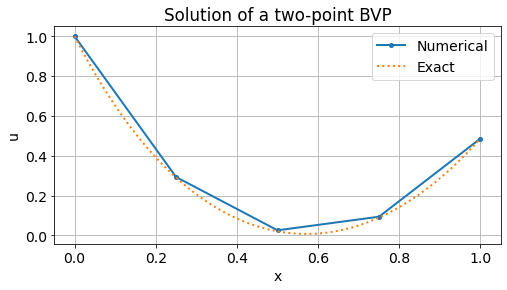

In [22]:
# Plot the solution of the BVP
xe = linspace(0,1,101)
plot(x,U,'.-')
plot(xe, u_eksakt(xe),':')              
xlabel('x')
ylabel('u')
legend(['Numerical','Exact'])
title('Solution of a two-point BVP');

Max error = 4.985e-03


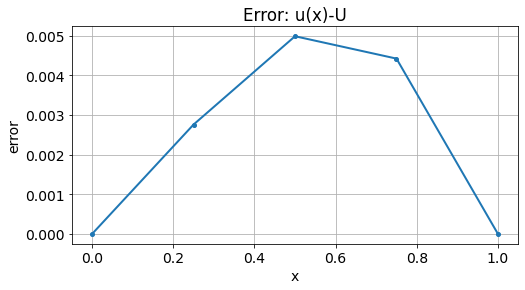

In [24]:
# Plot the error |u(x)-U| in the gridpoints
error = abs(u_eksakt(x)-U)
plot(x, error,'.-')
xlabel('x')
ylabel('error')
title('Error: u(x)-U');
print('Max error = {:.3e}'.format(max(abs(error))))

## Boundary conditions

To get a unique solution of a BVP (or a PDE), some information about the
solution, usually given on the boundaries has to be known. The most common boundary conditions are:
1. Dirichlet condition: The solution is known at the boundary.

2. Neumann condition: The derivative is known at the boundary.

3. Robin (or mixed) condition: A combination of those.

In the example above, Dirichlet conditions were used. We will now see
how to handle Neumann conditions. Robin conditions can be treated similarly. 

Given the BVP with a Neumann condition at the left boundary:

$$
u'' + p(x) u' + q(x) u = r(x), \qquad a \leq x \leq b, \qquad u'(a)=u'_a,
\quad u(b)=u_b.
$$

Here, $u'_a$ is some given value. In this case, the solution $u(a)$ and its
corresponding approximation $U_0$ are unknown, and we need some difference
formula also for the point $a=x_0$. The simplest option is to use a forward
difference

$$
u'_a = \frac{u(x_1)-u(x_0)}{h} + \mathcal{O}(h) \qquad \text{ resulting in }\qquad
   \frac{U_1-U_0}{h} = u'_a
$$

But this is only a first order approximation, and thus lower accuracy is to be
expected. We could also use a second order approximation using the values in the
grid points $x_0$, $x_1$ and $x_2$, but this will ruin the nice tridiagonal
structure of the coefficient matrix. 

Instead, use the idea of a *false
boundary*: 

Assume that the solution can be stretched outside the boundary $x=a$, all the
way to a fictitious grid point $x_{-1}=a-h$, where we also assume there is an
approximate and equally fictitious approximation $U_{-1}$ to $u(x_{-1})$. Then
we have two difference formulas in the point $a$, one for the BVP itself
and a central difference for the boundary conditions:

\begin{align*}
   \frac{U_{1}-2U_0+U_{-1}}{h^2} + p(x_0)\frac{U_{1}-U_{-1}}{2h} +    q(x_0) U_0 & =  r(x_0), \\ 
   \frac{U_1 - U_{-1}}{2h} &= u'_a.
\end{align*}

We can now solve the second equation with respect to $U_{-1}$, and insert the
solution into the first equation. This yields the new equation

$$
\frac{2U_1-2U_0-2hu'_a}{h^2} + p(x_0)u'_a + q(x_0)U_0 = r(x_0).
$$

So the only thing that has changed is the first equation. And since central differences have been used both for the BVP and the boundary condition, the overall order of this approximation can be proved to be 2.  

**Example 2:**

We consider the same example as before, but now with a Neumann condition at the left
boundary:

$$
u'' + 2u' - 3u = 9x, \qquad u'(0)=u'_a =-4, \quad u(1)=u_b = -2e^{-3}+e-5 \approx
0.48635073,
$$

which has the analytic solution $u(x)= e^{-3x}-2e^{x}-3x-2$.

The modified difference equation at the boundary $x_0=0$ is

$$
\frac{2U_1-2U_0-2u'_a h}{h^2} +2u'_a - 3U_0 = 0.
$$

We multiply this equation by $h^2$, and include the equation as the 
discretization for the grid point $x_0$.
With this, we obtain the system

\begin{align*}
 (-2-3h^2)U_0 - 2U_1 &= (2h-2h^2)u'_a, \\ 
 (1-h)U_{i-1} + (-2-3h^2)U_i + (1+h)U_{i+1} &= 9 h^2 x_i, && i=1, \ldots N-1, \\ 
 U_N &= u_b,
\end{align*}

which, for $N=4$ and $h=0.25$ becomes

$$
\left( \begin{array}{ccccc}
  -2.1875 & 2 & 0 & 0 & 0  \\ 
  0.75 & -2.1875 & 1.25 & 0 & 0 \\ 
 0 & 0.75 & -2.1875 & 1.25 & 0 \\ 
 0 & 0 & 0.75 & -2.1875 & 1.25 \\ 
 0 & 0 & 0 & 0 & 1 \\ 
\end{array}\right)\left(\begin{array}{c} U_{0} \\ U_1 \\ U_2 \\ U_3 \\ U_4
\end{array}\right) = \left(\begin{array}{c} -1.5  \\ 0.140625  \\  0.28125  \\ 
0.421875  \\  0.48635073 \end{array} \right).
$$

The solution of this is

$$
U_0 \approx 0.92103219, \quad U_1 \approx 0.25737896, \quad  U_2 \approx 0.01029386, \qquad U_3 \approx 0.08858688.
$$

**Problem 3:**

Now consider the two-point boundary problem from Example 2; that is,

$$
u'' + 2u' - 3u = 9x, \qquad u'(0)=u'_a =-4, \quad u(1)=u_b = -2e^{-3}+e-5
$$

which has the analytic solution $u(x)= e^{-3x}-2e^{x}-3x-2$.

Here we want you to test the two possible implementations of the Neumann boundary 
conditions discussed above.

**a)** Modify the matrix $A$ and right-hand $b$ so that you implement the Neumann boundary condition $u'(0)=u'_a =-4$ via the approximation $u'(a) \approx \frac{U_1-U_0}{h} = u'_a$. Now using the analytical solution, run a convergence study a là Problem 2.
Plot/write out the resulting EOC table. What convergence order do you get?

**b)** Now modify the matrix $A$ and right-hand $b$ so that you implement the Neumann boundary condition using the idea of a false boundary as described above. Redo the convergence study, plot/write out the resulting EOC table. What convergence order do you get this time?